In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
from scipy import interpolate

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # changes per computer
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 05/05/2020 20:19:35


In [2]:
opt_parms = { 'ovs': 4096,
             'surf_units': u.micron,
             'ca': 75,
             'ring_width': 5}

parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')
oap=[]

for surface_name in oap_labels:
    n_step = 'OAP {0}'.format(surface_name)
    file_loc=data_folder+'oap{0}_{1}CA'.format(surface_name, opt_parms['ca'])
    # create the object
    opt = psd.surfPSD(surf_name = n_step)
    opt.open_surf(fileloc=file_loc+'_surf.fits', surf_units = opt_parms['surf_units'])
    opt.open_mask(fileloc=file_loc+'_mask.fits')
    opt.calc_psd(oversamp = opt_parms['ovs'])
    print('PSD for {0} complete'.format(n_step))
    opt.calc_psd_radial(ring_width=opt_parms['ring_width'])
    print('Radial profile for {0} complete\n'.format(n_step))
    oap.append(opt)

PSD for OAP A complete
Radial profile for OAP A complete

PSD for OAP B complete
Radial profile for OAP B complete

PSD for OAP C complete
Radial profile for OAP C complete

PSD for OAP D complete
Radial profile for OAP D complete

PSD for OAP E complete
Radial profile for OAP E complete

PSD for OAP F complete
Radial profile for OAP F complete

PSD for OAP G complete
Radial profile for OAP G complete

PSD for OAP H complete
Radial profile for OAP H complete



In [3]:
# calculate the average PSD
avg_var = np.mean([obj.var.value for obj in oap])*oap[0].var.unit
avg_rms = np.mean([obj.rms.value for obj in oap])*oap[0].rms.unit

avg_psd_norm = np.mean([obj.psd_radial_norm.value for obj in oap], axis=0)*oap[0].psd_radial_norm.unit
avg_psd_cal = avg_psd_norm * avg_var
print('Average calibrated radial PSD complete')

Average calibrated radial PSD complete


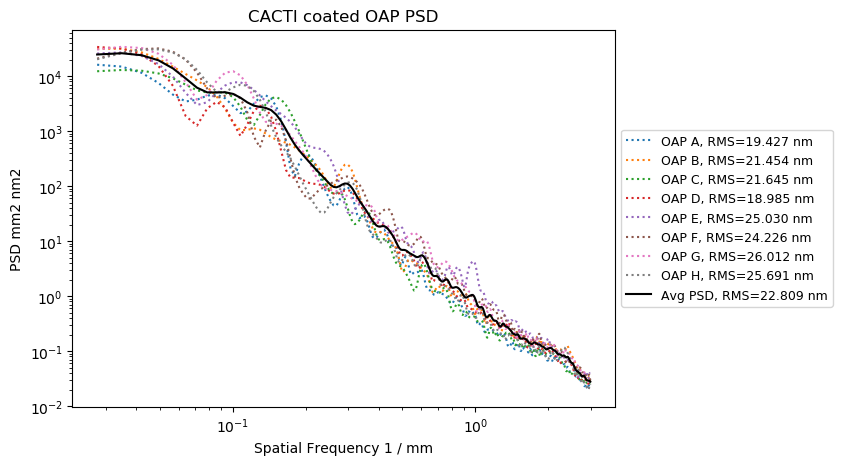

In [6]:
plt.figure(figsize=[7,5], dpi=100)
for obj in oap:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', label='{0}, RMS={1:.3f}'.format(obj.surf_name, obj.rms))
plt.loglog(oap[0].k_radial.value, avg_psd_cal.value, 'k', label='Avg PSD, RMS={0:.3f}'.format(avg_rms))
plt.xlabel('Spatial Frequency {0}'.format(oap[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(oap[0].psd_radial_cal.unit))
plt.title('CACTI coated OAP PSD')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))

### Calculate the RMS at low, mid, high spatial frequency bands.

In [17]:
# Evaluate the rms at low, mid, high spatial frequency 
k_lm = 1/(10*u.mm)
k_mh = 1/(1*u.mm)

klrms = []
kmrms = []
khrms = []
for obj in oap: 
    klrms.append(obj.calc_psd_rms(obj.k_min, k_lm))
    kmrms.append(obj.calc_psd_rms(k_lm, k_mh))
    khrms.append(obj.calc_psd_rms(k_mh, obj.k_max))

print('RMS calculations')
print('{0:>7} | {1:^9.3} | {2:^10.3} | {3:^8.4} | {4:^10.5}'.format('optic', 'low', 'mid', 'high', 'total'))
for no in range(0, len(oap_labels)):
    print('{0:>7} | {1:.3f} | {2:7.3f} | {3:.3f} | {4:.3f}'.format(oap[no].surf_name, klrms[no], kmrms[no], khrms[no], oap[no].rms))

RMS calculations
  optic |    low    |    mid     |   high   |   total   
  OAP A | 13.146 nm |  14.234 nm | 1.415 nm | 19.427 nm
  OAP B | 18.378 nm |  10.923 nm | 1.794 nm | 21.454 nm
  OAP C | 14.670 nm |  15.848 nm | 1.469 nm | 21.645 nm
  OAP D | 15.385 nm |  11.001 nm | 1.644 nm | 18.985 nm
  OAP E | 16.747 nm |  18.474 nm | 2.177 nm | 25.030 nm
  OAP F | 20.850 nm |  12.183 nm | 1.932 nm | 24.226 nm
  OAP G | 20.213 nm |  16.270 nm | 1.834 nm | 26.012 nm
  OAP H | 21.163 nm |  14.477 nm | 1.593 nm | 25.691 nm
